In [82]:
import numpy as np
import pandas as pd

df = pd.read_csv('/Users/amit/Desktop/Electricity Forecasting Model for Delhi/data/processed/processed_power_demand.csv')

In [83]:
df

,datetime,power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,wdir_sin,wdir_cos
0,2021-01-01 00:30:00,2014.00,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,30,0.000000,1.000000
1,2021-01-01 00:35:00,2005.63,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,35,0.000000,1.000000
2,2021-01-01 00:40:00,1977.60,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,40,0.000000,1.000000
3,2021-01-01 00:45:00,1976.44,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,45,0.000000,1.000000
4,2021-01-01 00:50:00,1954.37,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,50,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393435,2024-12-12 00:10:00,2146.84,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,10,-0.999848,-0.017452
393436,2024-12-12 00:15:00,2116.66,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,15,-0.999848,-0.017452
393437,2024-12-12 00:20:00,2082.77,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,20,-0.999848,-0.017452
393438,2024-12-12 00:25:00,2059.17,12.3,6.8,69.0,269.0,1.8,1019.4,2024,12,12,0,25,-0.999848,-0.017452


In [84]:
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.sort_values("datetime").reset_index(drop=True)

print("Shape:", df.shape)
print("Date range:", df["datetime"].min(), "->", df["datetime"].max())
print("Missing datetime:", df["datetime"].isna().sum())

df.head(3)

Shape: (393440, 15)
Date range: 2021-01-01 00:30:00 -> 2024-12-12 00:30:00
Missing datetime: 0


,datetime,power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,wdir_sin,wdir_cos
0,2021-01-01 00:30:00,2014.00,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,30,0.0,1.0
1,2021-01-01 00:35:00,2005.63,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,35,0.0,1.0
2,2021-01-01 00:40:00,1977.60,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,40,0.0,1.0


In [85]:
# All set to go no missing values, range is 2021 to 2024 , shape (393440,15)

In [86]:
# Train-Test split
import pandas as pd

# Choose how much recent data you want for final testing
TEST_DAYS = 90

# Find the last timestamp in your dataset
max_dt = df["datetime"].max()

# Cutoff date: everything before this is train, after is test
cutoff = max_dt - pd.Timedelta(days=TEST_DAYS)

train_df = df[df["datetime"] < cutoff].copy()
test_df  = df[df["datetime"] >= cutoff].copy()

print("Max datetime:", max_dt)
print("Cutoff datetime:", cutoff)

print("\nTrain rows:", len(train_df))
print("Train range:", train_df["datetime"].min(), "->", train_df["datetime"].max())

print("\nTest rows:", len(test_df))
print("Test range:", test_df["datetime"].min(), "->", test_df["datetime"].max())


Max datetime: 2024-12-12 00:30:00
Cutoff datetime: 2024-09-13 00:30:00

Train rows: 368829
Train range: 2021-01-01 00:30:00 -> 2024-09-13 00:25:00

Test rows: 24611
Test range: 2024-09-13 00:30:00 -> 2024-12-12 00:30:00


In [87]:
expected = pd.Timedelta(minutes=5)
test_delta = test_df["datetime"].diff().dropna()

print("% of 5-min intervals in test:", (test_delta == expected).mean() * 100)
print("Top deltas in test:")
print(test_delta.value_counts().head(5))

% of 5-min intervals in test: 99.61804144656644
Top deltas in test:
datetime
0 days 00:05:00    24516
0 days 01:20:00       16
0 days 01:05:00       10
0 days 01:25:00        8
0 days 00:15:00        8
Name: count, dtype: int64


In [88]:
# Baseline forecast: “Same time yesterday"

import pandas as pd
import numpy as np

full_s = df.set_index("datetime")["power demand"]
test_s = test_df.set_index("datetime")["power demand"]

shift = pd.Timedelta(hours=24)

y_pred = test_s.index.map(lambda t: full_s.get(t - shift, np.nan))
y_pred = pd.Series(y_pred, index=test_s.index, name="yhat_yesterday")

eval_df = pd.concat([test_s.rename("y_true"), y_pred], axis=1).dropna()

print("Eval rows:", len(eval_df), "out of", len(test_s))
eval_df.head()



Eval rows: 24059 out of 24611


,y_true,yhat_yesterday
datetime,,
2024-09-13 00:30:00,3993.89,1783.79
2024-09-13 00:35:00,3968.96,1780.57
2024-09-13 00:40:00,3959.46,1745.60
2024-09-13 00:45:00,3887.04,1733.75
2024-09-13 00:50:00,3927.55,1729.92


In [89]:
# Evaluate baseline (MAE, RMSE, SMAPE)
import numpy as np

y = eval_df["y_true"].values
yhat = eval_df["yhat_yesterday"].values

mae = np.mean(np.abs(y - yhat))
rmse = np.sqrt(np.mean((y - yhat)**2))

# SMAPE (robust alternative to MAPE)
smape = np.mean(2 * np.abs(y - yhat) / (np.abs(y) + np.abs(yhat) + 1e-9)) * 100

print(f"Baseline MAE  : {mae:.3f} kW")
print(f"Baseline RMSE : {rmse:.3f} kW")
print(f"Baseline SMAPE: {smape:.3f} %")


Baseline MAE  : 461.944 kW
Baseline RMSE : 676.053 kW
Baseline SMAPE: 11.338 %


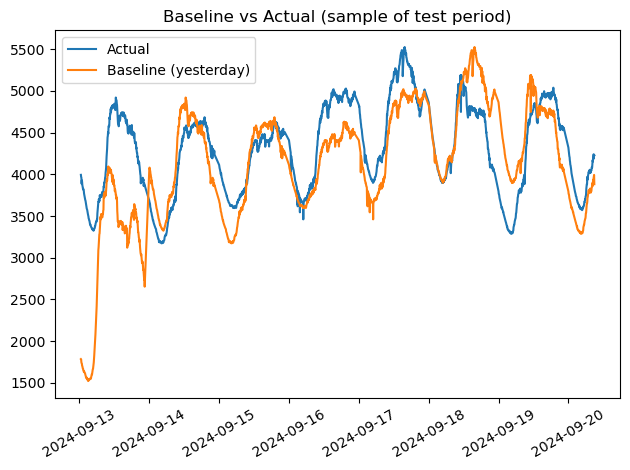

In [90]:
# visualitation check actual vs basline 

import matplotlib.pyplot as plt

sample = eval_df.iloc[:2000]  # first ~2000 points in test evaluation

plt.figure()
plt.plot(sample.index, sample["y_true"], label="Actual")
plt.plot(sample.index, sample["yhat_yesterday"], label="Baseline (yesterday)")
plt.title("Baseline vs Actual (sample of test period)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.legend()
plt.show()


In [91]:
# Baseline 2 - 'same as last week'

import pandas as pd
import numpy as np

full_s = df.set_index("datetime")["power demand"]
test_s = test_df.set_index("datetime")["power demand"]

shift_week = pd.Timedelta(days=7)

y_pred_week = test_s.index.map(lambda t: full_s.get(t - shift_week, np.nan))
y_pred_week = pd.Series(y_pred_week, index=test_s.index, name="yhat_last_week")

eval_week = pd.concat(
    [test_s.rename("y_true"), y_pred_week],
    axis=1
).dropna()

print("Eval rows (last week):", len(eval_week), "out of", len(test_s))
eval_week.head()


Eval rows (last week): 23956 out of 24611


,y_true,yhat_last_week
datetime,,
2024-09-13 00:30:00,3993.89,6865.32
2024-09-13 00:35:00,3968.96,6842.83
2024-09-13 00:40:00,3959.46,6822.28
2024-09-13 00:45:00,3887.04,6804.61
2024-09-13 00:50:00,3927.55,6806.05


In [92]:
# Evaluation of Baseline 2
y = eval_week["y_true"].values
yhat = eval_week["yhat_last_week"].values

mae_w = np.mean(np.abs(y - yhat))
rmse_w = np.sqrt(np.mean((y - yhat)**2))
smape_w = np.mean(
    2 * np.abs(y - yhat) / (np.abs(y) + np.abs(yhat) + 1e-9)
) * 100

print(f"Last-week MAE  : {mae_w:.3f} kW")
print(f"Last-week RMSE : {rmse_w:.3f} kW")
print(f"Last-week SMAPE: {smape_w:.3f} %")

Last-week MAE  : 984.194 kW
Last-week RMSE : 1370.586 kW
Last-week SMAPE: 23.927 %


In [93]:
# compare both baselines
compare_df = eval_df.join(
    eval_week["yhat_last_week"],
    how="inner"
)

compare_df.head()


,y_true,yhat_yesterday,yhat_last_week
datetime,,,
2024-09-13 00:30:00,3993.89,1783.79,6865.32
2024-09-13 00:35:00,3968.96,1780.57,6842.83
2024-09-13 00:40:00,3959.46,1745.60,6822.28
2024-09-13 00:45:00,3887.04,1733.75,6804.61
2024-09-13 00:50:00,3927.55,1729.92,6806.05


In [94]:
"Summary of take away"
'''We evaluated both daily (T−24h) and weekly (T−7d) seasonal naive baselines. 
The daily baseline achieved substantially lower error, indicating strong day-to-day regularity in demand, while the weekly baseline performed poorly, suggesting limited weekly repeatability.
Consequently, daily lags were prioritized in feature engineering'''

'We evaluated both daily (T−24h) and weekly (T−7d) seasonal naive baselines. \nThe daily baseline achieved substantially lower error, indicating strong day-to-day regularity in demand, while the weekly baseline performed poorly, suggesting limited weekly repeatability.\nConsequently, daily lags were prioritized in feature engineering'

In [95]:
# feature engineering

In [96]:
# Decide horizon 
HORIZON = 12  # 12 * 5 minutes = 1 hour

# lag feature >> Values of demand in the recent past.

df_feat = df.copy()

LAGS = [1, 3, 6, 12, 24, 288]  
# 1=5m, 3=15m, 6=30m, 12=1h, 24=2h, 288=24h

for lag in LAGS:
    df_feat[f"lag_{lag}"] = df_feat["power demand"].shift(lag)

In [97]:
# rolling stats >> They summarize recent behavior, not just single points.
# Ex - average demand in last hour ,volatility in last 1–3 hours

ROLL_WINDOWS = [6, 12, 24]  # 30 min, 1h, 2h

for w in ROLL_WINDOWS:
    df_feat[f"roll_mean_{w}"] = (
        df_feat["power demand"].shift(1).rolling(w).mean()
    )
    df_feat[f"roll_std_{w}"] = (
        df_feat["power demand"].shift(1).rolling(w).std()
    )


In [98]:
# Calendar (time-based) features
# Why calendar features matter
"""Electricity demand depends heavily on:
hour of day (morning/evening peaks),
day of week (weekday vs weekend)."""

df_feat["hour"] = df_feat["datetime"].dt.hour
df_feat["dayofweek"] = df_feat["datetime"].dt.dayofweek
df_feat["is_weekend"] = (df_feat["dayofweek"] >= 5).astype(int)


In [99]:
# Weather + wind direction features

import numpy as np

# Wind direction encoding
r = np.deg2rad(df_feat["wdir"])
df_feat["wdir_sin"] = np.sin(r)
df_feat["wdir_cos"] = np.cos(r)

In [100]:
# Create the target variable
df_feat["y"] = df_feat["power demand"].shift(-HORIZON)

In [101]:
#Drop rows with NaNs (expected)

'''NaNs come from:
lags,
rolling windows,
horizon shift.'''

feature_cols = [
    c for c in df_feat.columns
    if c not in ["datetime", "power demand", "y"]
]

df_model = df_feat.dropna(subset=feature_cols + ["y"]).copy()

print("Final modeling shape:", df_model.shape)


Final modeling shape: (393140, 30)


In [102]:
df_feat.columns

Index(['datetime', 'power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd',
       'pres', 'year', 'month', 'day', 'hour', 'minute', 'wdir_sin',
       'wdir_cos', 'lag_1', 'lag_3', 'lag_6', 'lag_12', 'lag_24', 'lag_288',
       'roll_mean_6', 'roll_std_6', 'roll_mean_12', 'roll_std_12',
       'roll_mean_24', 'roll_std_24', 'dayofweek', 'is_weekend', 'y'],
      dtype='object')

We engineered lagged demand features, rolling statistics, calendar variables, and weather features to capture short-term dynamics, daily seasonality, and exogenous effects. All features were constructed using only past information to avoid leakage, and the prediction target was defined as demand one hour ahead.

In [103]:
FEATURE_COLS = [
    # lags
    "lag_1", "lag_3", "lag_6", "lag_12", "lag_24", "lag_288",

    # rolling stats
    "roll_mean_6", "roll_std_6",
    "roll_mean_12", "roll_std_12",
    "roll_mean_24", "roll_std_24",

    # calendar
    "hour", "dayofweek", "is_weekend",

    # weather
    "temp", "dwpt", "rhum", "wspd", "pres",

    # wind (circular)
    "wdir_sin", "wdir_cos"
]

TARGET_COL = "y"


In [104]:
FEATURE_COLS

['lag_1',
 'lag_3',
 'lag_6',
 'lag_12',
 'lag_24',
 'lag_288',
 'roll_mean_6',
 'roll_std_6',
 'roll_mean_12',
 'roll_std_12',
 'roll_mean_24',
 'roll_std_24',
 'hour',
 'dayofweek',
 'is_weekend',
 'temp',
 'dwpt',
 'rhum',
 'wspd',
 'pres',
 'wdir_sin',
 'wdir_cos']

In [105]:
X = df_model[FEATURE_COLS]
y = df_model[TARGET_COL]

print(X.shape, y.shape)


(393140, 22) (393140,)


Train LightGBM (point forecast)

In [106]:
# Apply the same time-based split to df_model
import pandas as pd

# reuse the same cutoff from Step 3
cutoff = pd.Timestamp("2024-09-13 00:30:00")

train_m = df_model[df_model["datetime"] < cutoff].copy()
test_m  = df_model[df_model["datetime"] >= cutoff].copy()

print("Train rows:", len(train_m))
print("Test rows :", len(test_m))

print("Train range:", train_m["datetime"].min(), "->", train_m["datetime"].max())
print("Test range :", test_m["datetime"].min(),  "->", test_m["datetime"].max())


Train rows: 368541
Test rows : 24599
Train range: 2021-01-02 00:30:00 -> 2024-09-13 00:25:00
Test range : 2024-09-13 00:30:00 -> 2024-12-11 22:15:00


In [107]:
FEATURE_COLS = [
    # lags
    "lag_1", "lag_3", "lag_6", "lag_12", "lag_24", "lag_288",

    # rolling stats
    "roll_mean_6", "roll_std_6",
    "roll_mean_12", "roll_std_12",
    "roll_mean_24", "roll_std_24",

    # calendar
    "hour", "dayofweek", "is_weekend",

    # weather
    "temp", "dwpt", "rhum", "wspd", "pres",

    # wind
    "wdir_sin", "wdir_cos"
]

TARGET_COL = "y"
    
X_train = train_m[FEATURE_COLS]
y_train = train_m[TARGET_COL]

X_test = test_m[FEATURE_COLS]
y_test = test_m[TARGET_COL]

print(X_train.shape, X_test.shape)


(368541, 22) (24599, 22)


In [108]:
!pip install lightgbm

In [109]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(
    objective="regression",
    n_estimators=300,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4310
[LightGBM] [Info] Number of data points in the train set: 368541, number of used features: 22
[LightGBM] [Info] Start training from score 3951.682067


LGBMRegressor(learning_rate=0.05, n_estimators=300, n_jobs=-1,
              objective='regression', random_state=42)

In [110]:
import numpy as np

y_pred = lgbm.predict(X_test)

mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
smape = np.mean(
    2 * np.abs(y_test - y_pred) /
    (np.abs(y_test) + np.abs(y_pred) + 1e-9)
) * 100

print(f"LightGBM MAE  : {mae:.3f} kW")
print(f"LightGBM RMSE : {rmse:.3f} kW")
print(f"LightGBM SMAPE: {smape:.3f} %")


LightGBM MAE  : 122.567 kW
LightGBM RMSE : 231.125 kW
LightGBM SMAPE: 3.087 %


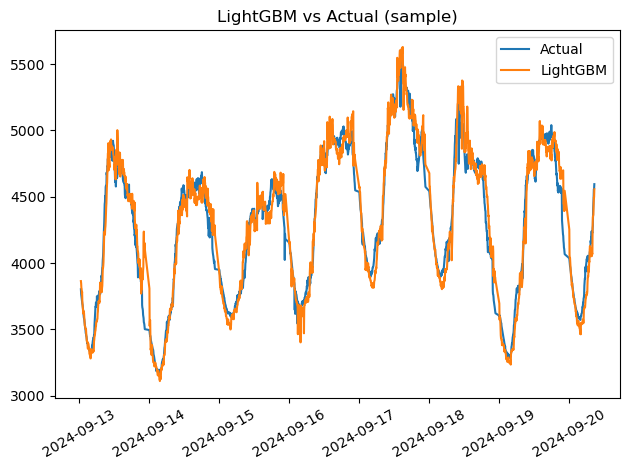

In [111]:
import matplotlib.pyplot as plt

sample = test_m.iloc[:2000]

plt.figure()
plt.plot(sample["datetime"], y_test.iloc[:2000], label="Actual")
plt.plot(sample["datetime"], y_pred[:2000], label="LightGBM")
plt.title("LightGBM vs Actual (sample)")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()


“A LightGBM regression model significantly outperformed the seasonal naive baseline, reducing MAE from 462 kW to 123 kW and SMAPE from 11.3% to 3.1%.
This demonstrates the effectiveness of combining lagged demand, rolling statistics, calendar variables, and weather features for short-horizon electricity demand forecasting.”

In [112]:
# Train quantile LightGBM models
from lightgbm import LGBMRegressor

def train_quantile_model(alpha):
    return LGBMRegressor(
        objective="quantile",
        alpha=alpha,
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    )

# Train models
q10_model = train_quantile_model(alpha=0.10)
q50_model = train_quantile_model(alpha=0.50)
q90_model = train_quantile_model(alpha=0.90)

q10_model.fit(X_train, y_train)
q50_model.fit(X_train, y_train)
q90_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4310
[LightGBM] [Info] Number of data points in the train set: 368541, number of used features: 22
[LightGBM] [Info] Start training from score 2207.110107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4310
[LightGBM] [Info] Number of data points in the train set: 368541, number of used features: 22
[LightGBM] [Info] Start training from score 3816.419922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

LGBMRegressor(alpha=0.9, learning_rate=0.05, n_estimators=300, n_jobs=-1,
              objective='quantile', random_state=42)

In [113]:
# Generate prediction intervals
y_p10 = q10_model.predict(X_test)
y_p50 = q50_model.predict(X_test)
y_p90 = q90_model.predict(X_test)

interval_df = test_m[["datetime"]].copy()
interval_df["y_true"] = y_test.values
interval_df["p10"] = y_p10
interval_df["p50"] = y_p50
interval_df["p90"] = y_p90

interval_df.head()


,datetime,y_true,p10,p50,p90
368829,2024-09-13 00:30:00,3802.52,3721.022704,3784.783484,3913.779453
368830,2024-09-13 00:35:00,3769.20,3721.593178,3782.984661,3894.789433
368831,2024-09-13 00:40:00,3753.39,3721.443671,3760.562199,3850.924129
368832,2024-09-13 00:45:00,3736.92,3677.712458,3753.893007,3850.924129
368833,2024-09-13 00:50:00,3720.94,3621.447207,3712.602477,3717.099610


In [114]:
# Evaluate uncertainty quality

# Metric 1: Coverage
coverage_80 = (
    (interval_df["y_true"] >= interval_df["p10"]) &
    (interval_df["y_true"] <= interval_df["p90"])
).mean()

print(f"80% interval coverage: {coverage_80*100:.2f}%")

# Metric 2: Interval width “How wide is the uncertainty band?”

interval_df["interval_width_80"] = interval_df["p90"] - interval_df["p10"]

print("Average 80% interval width (kW):",
      interval_df["interval_width_80"].mean())

80% interval coverage: 72.34%
Average 80% interval width (kW): 297.9016738325906


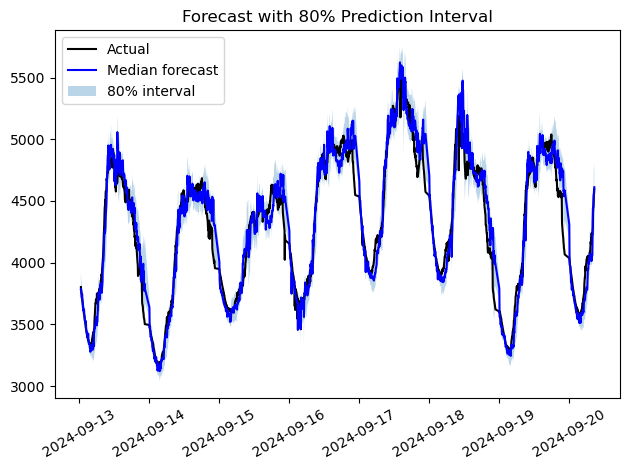

In [115]:
# Visualize uncertainty bands
import matplotlib.pyplot as plt

sample = interval_df.iloc[:2000]

plt.figure()
plt.plot(sample["datetime"], sample["y_true"], label="Actual", color="black")
plt.plot(sample["datetime"], sample["p50"], label="Median forecast", color="blue")

plt.fill_between(
    sample["datetime"],
    sample["p10"],
    sample["p90"],
    alpha=0.3,
    label="80% interval"
)

plt.title("Forecast with 80% Prediction Interval")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()


Initial quantile models were slightly under-covering, highlighting sharp demand ramps as the main source of uncertainty.”

In [116]:
# 95% interval quantiles
q025_model = train_quantile_model(alpha=0.025)
q975_model = train_quantile_model(alpha=0.975)

q025_model.fit(X_train, y_train)
q975_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4310
[LightGBM] [Info] Number of data points in the train set: 368541, number of used features: 22
[LightGBM] [Info] Start training from score 1644.224976
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4310
[LightGBM] [Info] Number of data points in the train set: 368541, number of used features: 22
[LightGBM] [Info] Start training from score 6610.455566


LGBMRegressor(alpha=0.975, learning_rate=0.05, n_estimators=300, n_jobs=-1,
              objective='quantile', random_state=42)

In [117]:
# Generate 95% interval predictions
y_p025 = q025_model.predict(X_test)
y_p975 = q975_model.predict(X_test)

interval_df["p025"] = y_p025
interval_df["p975"] = y_p975

interval_df.head()


,datetime,y_true,p10,p50,p90,interval_width_80,p025,p975
368829,2024-09-13 00:30:00,3802.52,3721.022704,3784.783484,3913.779453,192.756749,3721.957912,4048.412379
368830,2024-09-13 00:35:00,3769.20,3721.593178,3782.984661,3894.789433,173.196255,3720.810561,3994.146915
368831,2024-09-13 00:40:00,3753.39,3721.443671,3760.562199,3850.924129,129.480458,3720.810561,3947.653894
368832,2024-09-13 00:45:00,3736.92,3677.712458,3753.893007,3850.924129,173.211671,3666.801606,3934.518515
368833,2024-09-13 00:50:00,3720.94,3621.447207,3712.602477,3717.099610,95.652403,3618.488555,3902.147213


In [118]:
# Evaluate 95% interval quality
coverage_95 = (
    (interval_df["y_true"] >= interval_df["p025"]) &
    (interval_df["y_true"] <= interval_df["p975"])
).mean()

print(f"95% interval coverage: {coverage_95*100:.2f}%")


95% interval coverage: 91.82%


In [119]:
interval_df["interval_width_95"] = (
    interval_df["p975"] - interval_df["p025"]
)

print("Average 95% interval width (kW):",
      interval_df["interval_width_95"].mean())


Average 95% interval width (kW): 612.2219125989117


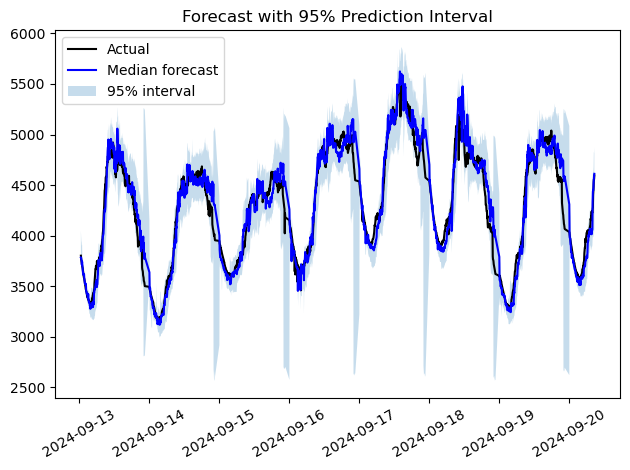

In [120]:
# Visualize 95% interval

import matplotlib.pyplot as plt

sample = interval_df.iloc[:2000]

plt.figure()
plt.plot(sample["datetime"], sample["y_true"], label="Actual", color="black")
plt.plot(sample["datetime"], sample["p50"], label="Median forecast", color="blue")

plt.fill_between(
    sample["datetime"],
    sample["p025"],
    sample["p975"],
    alpha=0.25,
    label="95% interval"
)

plt.title("Forecast with 95% Prediction Interval")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()


In [121]:
# Compute non-conformity scores
import numpy as np

# For 95% interval
lower = interval_df["p025"].values
upper = interval_df["p975"].values
y_true = interval_df["y_true"].values

# non-conformity score
nc_scores = np.maximum(lower - y_true, y_true - upper)
nc_scores = np.maximum(nc_scores, 0)


In [122]:
# Find scaling factor
alpha = 0.05  # for 95% interval
q_hat = np.quantile(nc_scores, 1 - alpha)

print("Calibration offset (kW):", q_hat)


Calibration offset (kW): 27.697226176866543


In [123]:
# Apply calibrated interval
interval_df["p025_cal"] = interval_df["p025"] - q_hat
interval_df["p975_cal"] = interval_df["p975"] + q_hat


In [124]:
# Re-check coverage
coverage_95_cal = (
    (interval_df["y_true"] >= interval_df["p025_cal"]) &
    (interval_df["y_true"] <= interval_df["p975_cal"])
).mean()

print(f"Calibrated 95% coverage: {coverage_95_cal*100:.2f}%")

print("New average width (kW):",
      (interval_df["p975_cal"] - interval_df["p025_cal"]).mean())


Calibrated 95% coverage: 95.00%
New average width (kW): 667.6163649526451


In [125]:
# 7. Anomaly Detection (Forecast-driven)

In [126]:
# Flag anomalies
interval_df["anomaly"] = (
    (interval_df["y_true"] < interval_df["p025_cal"]) |
    (interval_df["y_true"] > interval_df["p975_cal"])
)

interval_df["anomaly_type"] = "normal"
interval_df.loc[
    interval_df["y_true"] > interval_df["p975_cal"],
    "anomaly_type"
] = "high_load"

interval_df.loc[
    interval_df["y_true"] < interval_df["p025_cal"],
    "anomaly_type"
] = "low_load"

print(interval_df["anomaly_type"].value_counts())


anomaly_type
normal       23369
high_load      745
low_load       485
Name: count, dtype: int64


In [127]:
# 7.2 — Anomaly rate sanity check
anomaly_rate = interval_df["anomaly"].mean() * 100
print(f"Anomaly rate: {anomaly_rate:.2f}%")


Anomaly rate: 5.00%


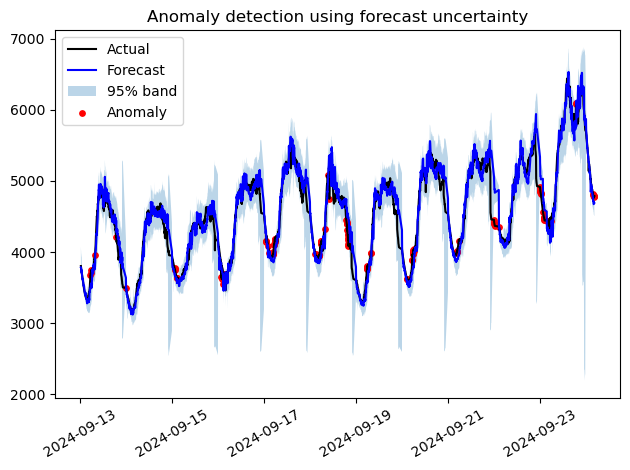

In [128]:
# Visualize anomalies
import matplotlib.pyplot as plt

sample = interval_df.iloc[:3000]

plt.figure()
plt.plot(sample["datetime"], sample["y_true"], label="Actual", color="black")
plt.plot(sample["datetime"], sample["p50"], label="Forecast", color="blue")

plt.fill_between(
    sample["datetime"],
    sample["p025_cal"],
    sample["p975_cal"],
    alpha=0.3,
    label="95% band"
)

# highlight anomalies
anoms = sample[sample["anomaly"]]
plt.scatter(
    anoms["datetime"],
    anoms["y_true"],
    color="red",
    s=15,
    label="Anomaly"
)

plt.title("Anomaly detection using forecast uncertainty")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()


“Anomalies were identified using forecast-driven thresholds derived from calibrated 95% prediction intervals. Observations falling outside the interval were flagged as anomalous and further classified into high-load and low-load events. The resulting anomaly rate was 5.0%, matching the theoretical expectation and confirming correct uncertainty calibration.”

In [129]:
# Explainability (Feature Importance + SHAP)
import pandas as pd

fi = pd.Series(
    lgbm.feature_importances_,
    index=FEATURE_COLS
).sort_values(ascending=False)

fi.head(15)


hour           2025
lag_1          1198
lag_288         747
temp            722
pres            541
lag_24          487
roll_std_24     424
roll_std_12     407
dwpt            388
roll_std_6      314
rhum            271
lag_12          236
wdir_sin        214
dayofweek       202
wdir_cos        163
dtype: int32

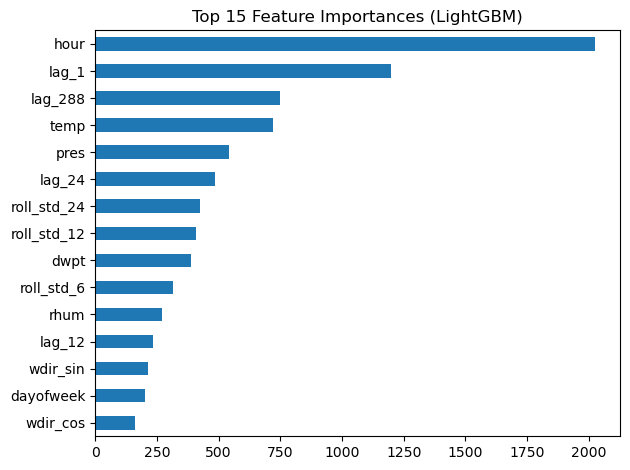

In [130]:
import matplotlib.pyplot as plt

fi.head(15).sort_values().plot(kind="barh")
plt.title("Top 15 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()


In [131]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [132]:
import shap

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

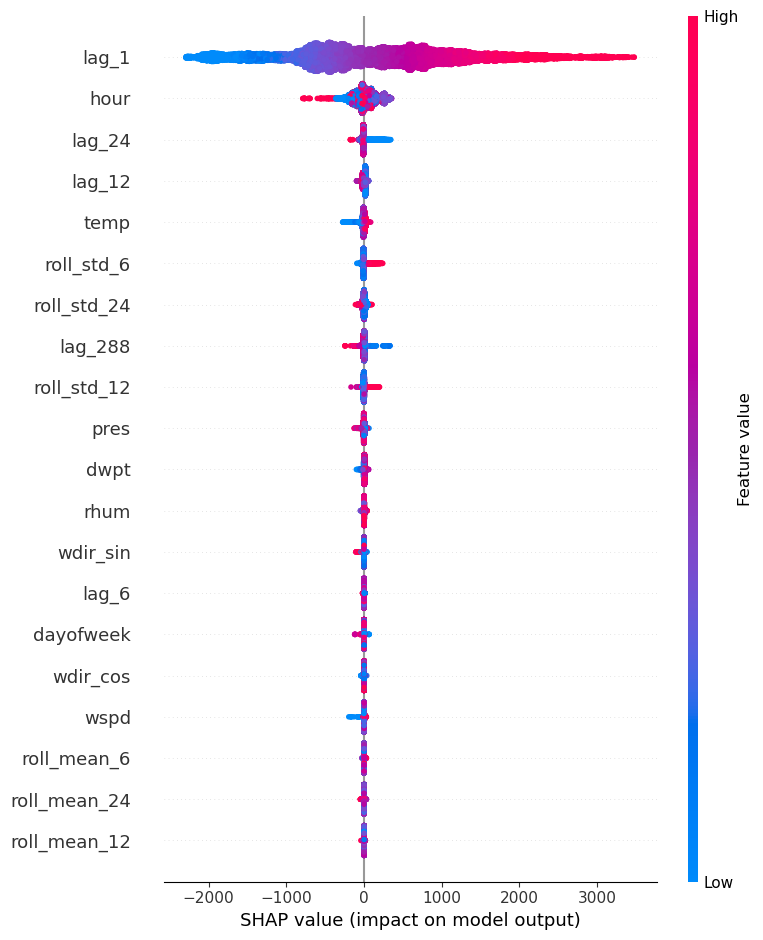

In [133]:
shap.summary_plot(shap_values, X_test, show=True)

In [134]:
# explaining specific anomaly

anom_idx = interval_df[interval_df["anomaly"]].index[0]

X_anom = X_test.loc[anom_idx:anom_idx]


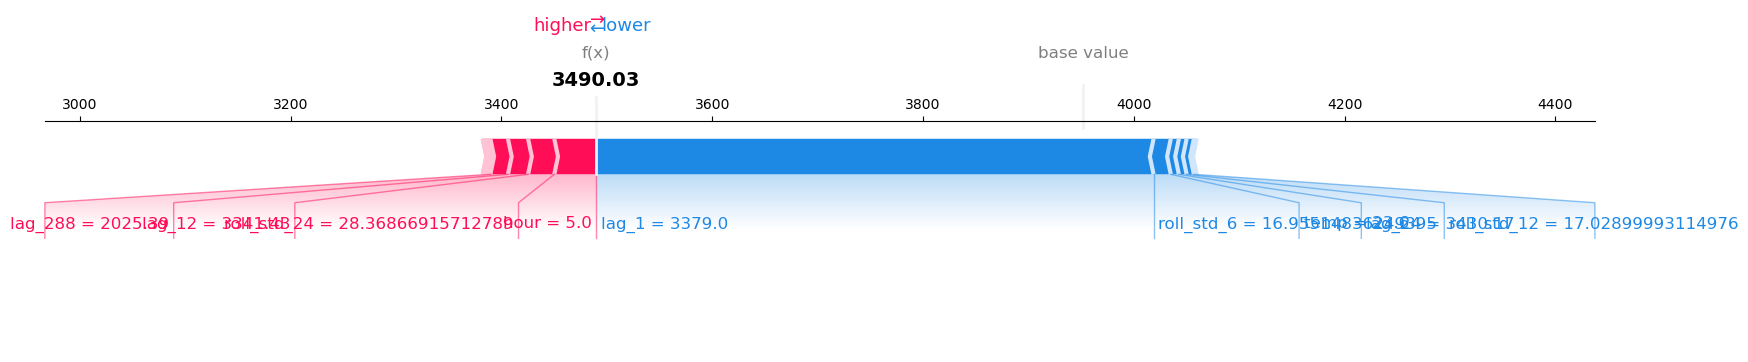

In [135]:
shap.force_plot(
    explainer.expected_value,
    explainer.shap_values(X_anom),
    X_anom,
    matplotlib=True
)


In [136]:
import joblib
import json
import os

os.makedirs("artifacts", exist_ok=True)

# save models
joblib.dump(lgbm, "artifacts/model_p50.pkl")
joblib.dump(q025_model, "artifacts/model_p025.pkl")
joblib.dump(q975_model, "artifacts/model_p975.pkl")

# save calibration
with open("artifacts/calibration.json", "w") as f:
    json.dump({"q_hat": float(q_hat)}, f)

# save feature schema
with open("artifacts/features.json", "w") as f:
    json.dump(FEATURE_COLS, f)

# save predictions
interval_df.to_csv("artifacts/interval_predictions.csv", index=False)

print("✅ ALL ARTIFACTS SAVED SUCCESSFULLY")


✅ ALL ARTIFACTS SAVED SUCCESSFULLY


In [137]:
with open("artifacts/calibration.json", "w") as f:
    json.dump({"q_hat": float(q_hat)}, f)

print("✅ Calibration saved.")


✅ Calibration saved.


In [138]:
with open("artifacts/features.json", "w") as f:
    json.dump(FEATURE_COLS, f)

print("✅ Feature schema saved.")


✅ Feature schema saved.


In [139]:
interval_df.to_csv("artifacts/interval_predictions.csv", index=False)

In [140]:
import os
print(os.getcwd())


/Users/amit/Desktop/Electricity Forecasting Model for Delhi/notebooks


In [142]:
df_feat.to_parquet("artifacts/feature_store.parquet", index=False)

In [143]:
import pandas as pd

test = pd.read_parquet("artifacts/feature_store.parquet")
print(test.shape)
print(test.columns)


(393440, 30)
Index(['datetime', 'power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd',
       'pres', 'year', 'month', 'day', 'hour', 'minute', 'wdir_sin',
       'wdir_cos', 'lag_1', 'lag_3', 'lag_6', 'lag_12', 'lag_24', 'lag_288',
       'roll_mean_6', 'roll_std_6', 'roll_mean_12', 'roll_std_12',
       'roll_mean_24', 'roll_std_24', 'dayofweek', 'is_weekend', 'y'],
      dtype='object')
